In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
b
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load the image and mask

In [3]:
image_files = os.listdir('dataset/image/')
mask_files = os.listdir('dataset/mask/')

In [4]:
def make_same_name(image_files):
    image_path = []
    mask_path = []
    for i in range(len(image_files)):
        common_part = image_files[i].split('.')[0]

        image_file = common_part+'.tif'
        mask_file  = common_part+'_mask.tif' 
        
        # create path
        image_file = os.path.join('dataset/image',image_file)
        mask_file  = os.path.join('dataset/mask',mask_file)
        # append the image and mask
        image_path.append(image_file)
        mask_path.append(mask_file)
        
    return image_path,mask_path

In [5]:
image_path,mask_path = make_same_name(image_files)

## Plot some images and masks

In [6]:
def plot_from_img_path(rows,columns,image_file,mask_file):
    fig = plt.figure(figsize=(12, 12))

    for i in range(1, rows*columns + 1):
        fig.add_subplot(rows, columns, i)

        image_path = image_file[i]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = mask_file[i]
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
        plt.title(f"Image {i}")

    plt.tight_layout()
    plt.show()

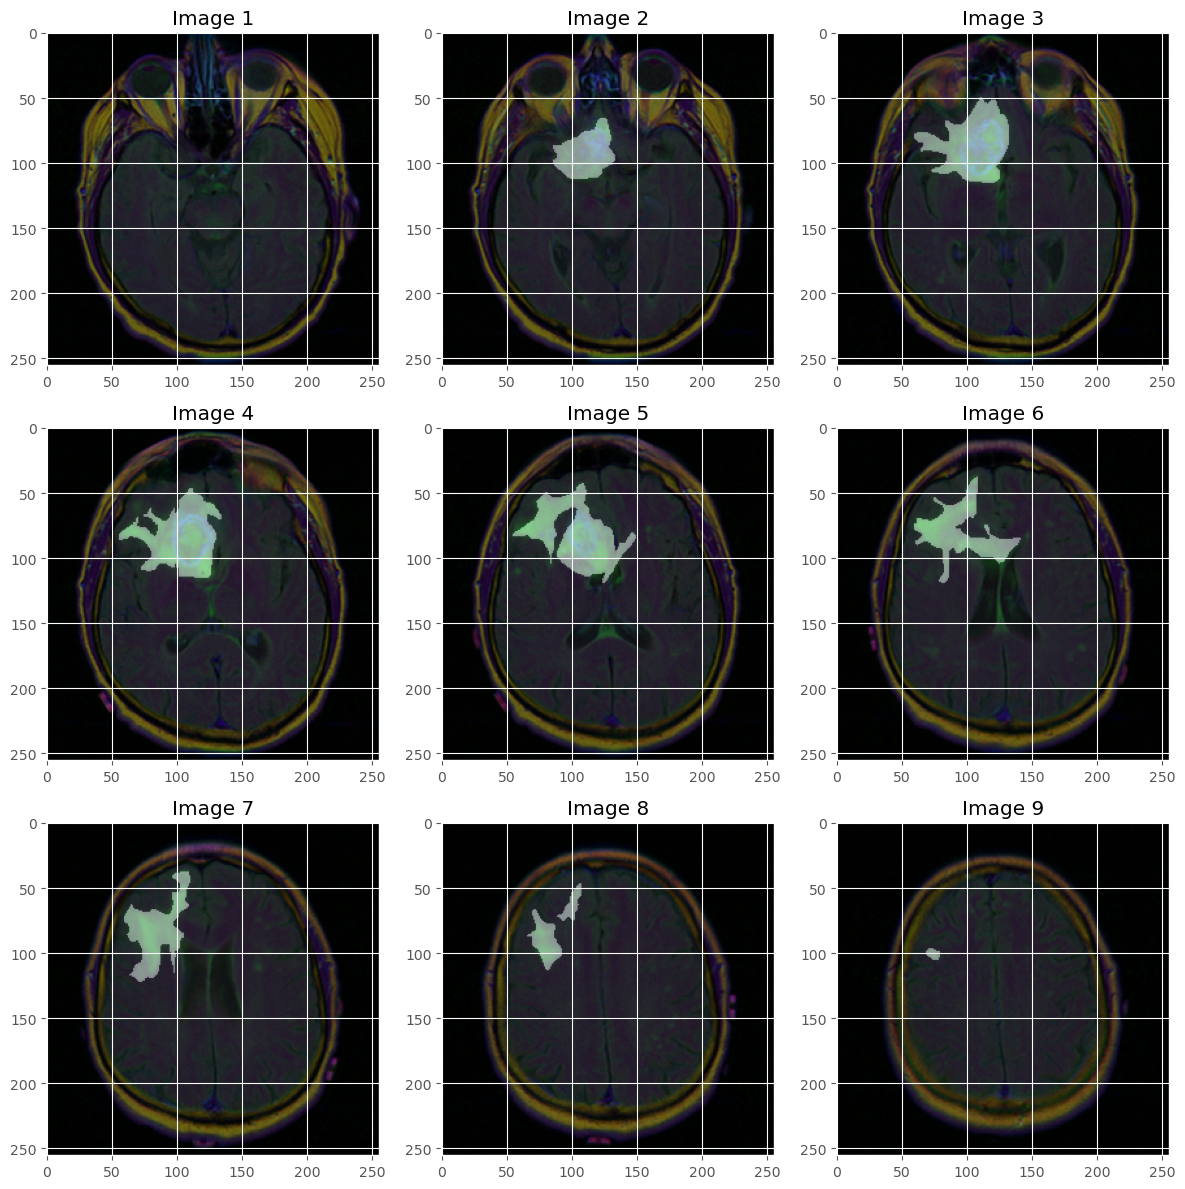

In [7]:
plot_from_img_path(3,3,image_path,mask_path)

In [8]:
def preprocessing(image_path,mask_path,size=(128,128) ):
    decode_image = []
    decode_mask  = []
    
    for i in range(len(image_path)):
        image = cv2.imread(image_path[i],cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(mask_path[i],cv2.IMREAD_GRAYSCALE)
        #resize the image and mask
        image_reshaped = cv2.resize(image,size)
        mask_reshaped  = cv2.resize(mask,size)
        
        decode_image.append(image_reshaped)
        decode_mask.append(mask_reshaped)
    image_dataset = tf.data.Dataset.from_tensor_slices(decode_image)
    mask_dataset = tf.data.Dataset.from_tensor_slices(decode_mask)
    
    return image_dataset,mask_dataset

In [9]:
image,mask = preprocessing(image_path,mask_path)

In [10]:
def normalize_image(image):
    
    image = image/255
    return image
def normalize_mask(mask):
    
    mask = mask/255
    mask = tf.expand_dims(mask,axis=-1)
    zero = tf.zeros(shape=mask.shape)
    ones = tf.ones(shape=mask.shape)
    
    greater_mask = tf.math.greater(mask, 0.5)
    lesser_equal_mask = tf.math.less_equal(mask, 0.5)
    # Assign 1 to values greater than 0.5
    mask = tf.where(greater_mask,mask,zero)
    # Assign 0 to values less than or equal to 0.5
    mask = tf.where(lesser_equal_mask, mask, ones)
    return mask

In [11]:
image_normalized = image.map(lambda x: normalize_image(x))
mask_normalized = mask.map(lambda x: normalize_mask(x))

In [12]:
sample_image = image_normalized.as_numpy_iterator()
sample_mask = mask_normalized.as_numpy_iterator()

In [13]:
_img =sample_image.next()
_mask = sample_mask.next()

In [14]:
def plot_sample_dataset(image,mask):
    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(image)
    arr[0].set_title('Image')
    arr[1].imshow(mask,cmap='gray')
    arr[1].set_title('Segmentation')
    plt.show()

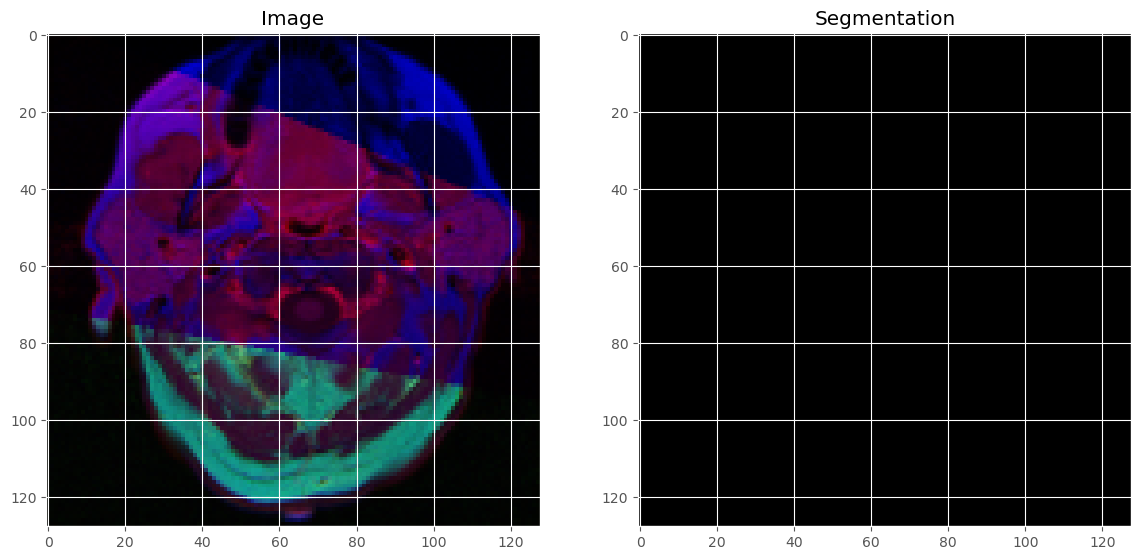

In [15]:
plot_sample_dataset(_img,_mask)

In [16]:
def U_net(input_size= (128,128,3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    
    up6 = concatenate(
        [Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5),conv4],axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3],axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2],axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1,],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
data = tf.data.Dataset.zip((image_normalized, mask_normalized))

In [19]:
train_data = data.take(round(len(data) * 0.7))

# Validation partition
validation_data = data.skip(round(len(data) * 0.7))
validation_data = validation_data.take(round(len(data) * 0.2))

# Test partition
test_data = data.skip(round(len(data) * 0.9))

In [20]:
# Print the number of samples in each partition
print("Train Data Samples:", tf.data.experimental.cardinality(train_data).numpy())
print("Validation Data Samples:", tf.data.experimental.cardinality(validation_data).numpy())
print("Test Data Samples:", tf.data.experimental.cardinality(test_data).numpy())

Train Data Samples: 2750
Validation Data Samples: 786
Test Data Samples: 393


In [21]:
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

validation_data = validation_data.batch(8)
validation_data = validation_data.prefetch(4)

In [22]:
# Print the number of samples in each partition
print("Train Data Samples:", tf.data.experimental.cardinality(train_data).numpy())
print("Validation Data Samples:", tf.data.experimental.cardinality(validation_data).numpy())
print("Test Data Samples:", tf.data.experimental.cardinality(test_data).numpy())

Train Data Samples: 344
Validation Data Samples: 99
Test Data Samples: 393


In [23]:
train_image_data, train_mask_data = zip(*train_data)
validation_image_data, validation_mask_data = zip(*validation_data)
test_image_data, test_mask_data = zip(*test_data)

In [26]:

EPOCH = 100
batch_size = 8
learning_rate = 1e-4
smooth=100


In [27]:
model = U_net(input_size=(128,128,3))

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_11 (Conv2D)             (None, 16, 16, 512)  2359808     ['activation_10[0][0]']          
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_11[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_11 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_5[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 32, 32, 256)  524544     ['activation_11[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatena

In [32]:
decay_rate = learning_rate / EPOCH
opt = Adam(learning_rate=learning_rate,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=None,
          decay=decay_rate)
decay_rate = learning_rate/ EPOCH
#model compile
model.compile(optimizer=opt,
              loss='binary_crossentropy',
             metrics=['binary_accuracy'])
callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

In [ ]:
history = model.fit(
    train_data,
    batch_size=batch_size,
    epochs=100,
    callbacks=callbacks,
    validation_data=validation_data
)

Epoch 1/100
